ЗАДАНИЕ

Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров (да, обычно в таких компаниях есть приложение для курьеров и отдельно приложение для потребителей).

У вас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности. 

Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой. 

Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy.stats import normaltest
%matplotlib inline

In [2]:
sns.set(
    font_scale = 2, 
    style = "whitegrid", 
    rc = {'figure.figsize':(15,10)})

In [3]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-tulnikov-27/STATISTIKA/experiment_lesson_4.csv')

order_id - id заказа

delivery_time - время доставки в минутах

district - район доставки

experiment_group - экспериментальная группа

In [4]:
df.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


Для начала давайте сформулируем гипотезы для проверки

Нулевая гипотеза (H0): Разницы между средним временем доставки в тестовой и контрольной группе нет

Альтернативная гипотеза (H1): Разница между средним временем доставки в тестовой и контрольной группе есть

Сопоставьте графики распределения и  экспериментальные группы

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

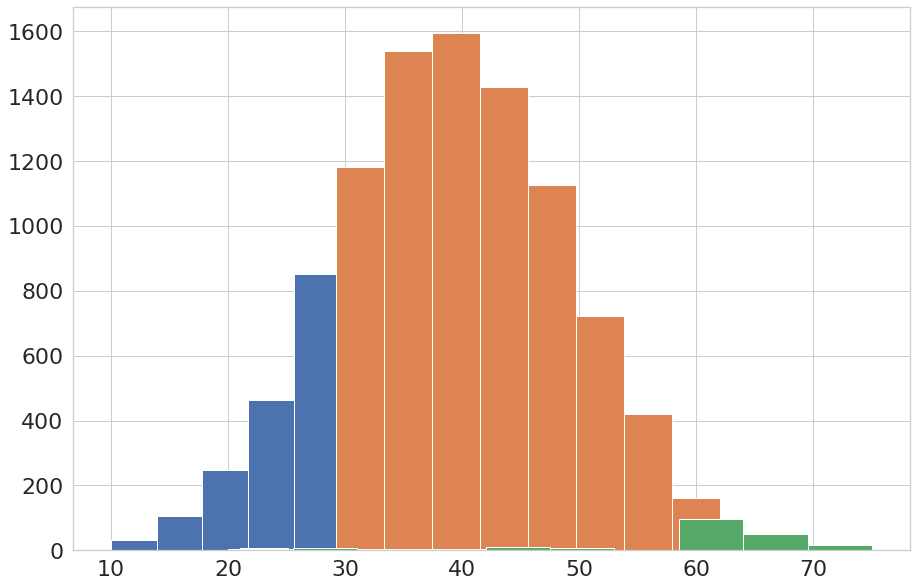

In [5]:
df.query('experiment_group == "test"').groupby('district').delivery_time.hist()

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

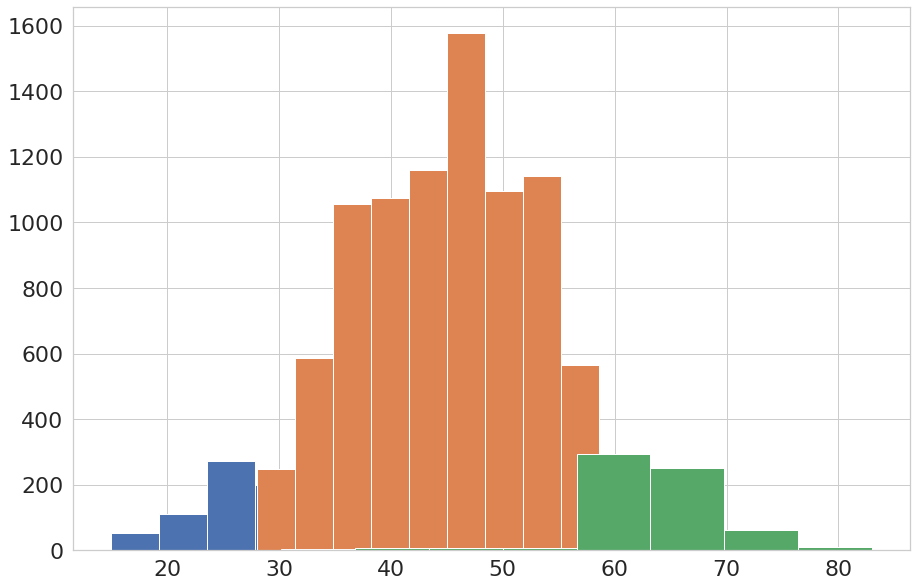

In [6]:
df.query('experiment_group == "control"').groupby('district').delivery_time.hist()

Посчитаем количество наблюдений в тестовой и контрольной группе. На сколько по модулю отличается количество наблюдений в тесте и контроле?

In [7]:
(df.query('experiment_group == "control"').count()) - (df.query('experiment_group == "test"').count())

order_id           -12
delivery_time      -12
district           -12
experiment_group   -12
dtype: int64

Теперь давайте изучим наши распределения. Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле.

In [8]:
control_group = df.query('experiment_group == "control"')

In [9]:
test_group = df.query('experiment_group == "test"')

In [10]:
control_group1 = control_group.drop(columns = ['district', 'experiment_group'])

In [11]:
test_group1 = test_group.drop(columns = ['district', 'experiment_group'])

 Для того, чтобы проверить нормальность распределения, я использую тест Агостино-Пирсона по функции scipy.stats.normaltest().
 
Этот тест показывает, что значения в тестовой группе распределены 
НЕНОРМАЛЬНО

В контрольной группе распределение является 
НОРМАЛЬНЫМ

Стандартное отклонение времени доставки в тесте равно 9.88

Стандартное отклонение времени доставки в контроле равно 9.99

In [12]:
std_control_group = control_group.delivery_time.std()
std_control_group.round(2)

9.99

In [13]:
std_test_group = test_group.delivery_time.std()
std_test_group.round(2)

9.88

In [14]:
normaltest(control_group1)

NormaltestResult(statistic=array([8.77972415e+03, 2.53497554e-01]), pvalue=array([0.        , 0.88095496]))

In [15]:
normaltest(test_group1)

NormaltestResult(statistic=array([8.79038041e+03, 7.02415709e+00]), pvalue=array([0.        , 0.02983484]))

Сравню средние в тесте и контроле.

Для сравнения средних в данных экспериментальных группах я использую 
STUDENT'S T-TEST
. Статистика в тесте равна -43
, p-value 
<= 0.05
.

In [16]:
ttest_ind(df[df.experiment_group == 'test'].delivery_time,
          df[df.experiment_group == 'control'].delivery_time)

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

Среднее время доставки в тестовой группе по сравнению с контрольной изменилось на 13.35%

In [17]:
round((1 - (test_group.delivery_time.mean() / control_group.delivery_time.mean())) * 100,2)

13.35

По итогу раскатываем новый алгоритм на всех, так как среднее время доставки статистически значимо изменилось. Среднее время доставки в тесте меньше, чем в контроле.